In [27]:
import numpy as np
import matplotlib.pyplot as plt
import audacity
import TransferFunctions as tf
import scipy.signal as sig
import peakutils

%matplotlib notebook

In [28]:
acquisitions = ["2301", "2301-2"]
runs = 17

dfiles = []
for acqno, acq in enumerate(acquisitions):
    if acqno == 0:
        dfiles.append(["ALL_DATA/transfer/b-foot/2tieclip_reference_sines.aup"])
    else:
        dfiles.append([])
    for r in range(runs):
        acqfiles = 'ALL_DATA/transfer/b-foot/%s_closing_%d.aup' % (acq, r)
        dfiles[acqno].append(acqfiles)
        
# reffile = "ALL_DATA/transfer/b-foot/2tieclip_reference_sines.aup"

In [29]:
# Load File, read data, and pad to have same length on all channels

nfft=1024*2

tfdata = [[] for i in range(len(dfiles))]

for n in range(len(dfiles)):
    for file in dfiles[n]:
        print(file)
        au = audacity.Aup(file)
        rdata = []
        maxl = 0
        for ii in range(au.nchannels):
            rdata.append(au.get_channel_data(ii))
            maxl = max(maxl,len(rdata[-1]))

        data = np.zeros((maxl,len(rdata)))
        for ii,rd in enumerate(rdata):
            data[:len(rd),ii]=rd

        delay=tf.determineDelay(data[:,0]/np.mean(data[:,0]),data[:,2]/np.mean(data[:,2]),maxdel=2**15)
        print("Delay: %d samples"%delay)
        data[:,0]=np.roll(data[:,0],delay)

        sr=au.rate

        tfxy,ff=tf.tfe(data[:,3],data[:,2],Fs=sr,NFFT=nfft)
        #tfxy,ff=my_tfe(data[:,3],data[:,2],Fs=sr,NFFT=nfft)
        #coh,ff=tf.cohere(data[:,1],data[:,2],Fs=sr,NFFT=nfft)
        ff,coh=sig.coherence(data[:,2],data[:,3],fs=sr,nperseg=nfft)

        datadict={'tf':tfxy,'coh':coh}

        for chno in [au.nchannels-2,au.nchannels-1]:
            tfxy,ff=tf.tfe(data[:,chno],data[:,0],Fs=sr,NFFT=nfft)
            #coh,ff=tf.cohere(data[:,1],data[:,2],Fs=sr,NFFT=nfft)
            # ff,coh=sig.coherence(data[:,0],data[:,chno],fs=sr,nperseg=nfft)
            datadict['mic%d'%(chno-1)]=tfxy


        datadict['sensRMS']=np.sqrt(np.mean((data[:,1]-np.mean(data[:,1]))**2))

        tfdata[n].append(datadict)

ALL_DATA/transfer/b-foot/2tieclip_reference_sines.aup
Delay: 1763 samples
ALL_DATA/transfer/b-foot/2301_closing_0.aup
Delay: 1763 samples
ALL_DATA/transfer/b-foot/2301_closing_1.aup
Delay: 1763 samples
ALL_DATA/transfer/b-foot/2301_closing_2.aup
Delay: 1763 samples
ALL_DATA/transfer/b-foot/2301_closing_3.aup
Delay: 1763 samples
ALL_DATA/transfer/b-foot/2301_closing_4.aup
Delay: 1763 samples
ALL_DATA/transfer/b-foot/2301_closing_5.aup
Delay: 1763 samples
ALL_DATA/transfer/b-foot/2301_closing_6.aup
Delay: 1763 samples
ALL_DATA/transfer/b-foot/2301_closing_7.aup
Delay: 1763 samples
ALL_DATA/transfer/b-foot/2301_closing_8.aup
Delay: 1763 samples
ALL_DATA/transfer/b-foot/2301_closing_9.aup
Delay: 1763 samples
ALL_DATA/transfer/b-foot/2301_closing_10.aup
Delay: 1763 samples
ALL_DATA/transfer/b-foot/2301_closing_11.aup
Delay: 1763 samples
ALL_DATA/transfer/b-foot/2301_closing_12.aup
Delay: 1763 samples
ALL_DATA/transfer/b-foot/2301_closing_13.aup
Delay: 1763 samples
ALL_DATA/transfer/b-foot/2

<IPython.core.display.Javascript object>


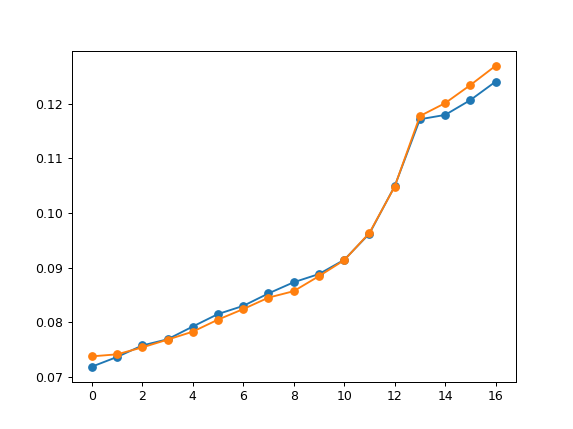

In [30]:
import re
positions = [[] for i in range(len(dfiles))]

plt.figure()

for n in range(len(dfiles)):
    for file in dfiles[n]:
        matches = re.findall('_[0-9]+',file)
        thispos = np.nan
        if len(matches) > 0:
            thispos = int(matches[0][1:])

        positions[n].append(thispos)

    plt.plot(positions[n], [xx['sensRMS'] for xx in tfdata[n]],'o-')

<IPython.core.display.Javascript object>


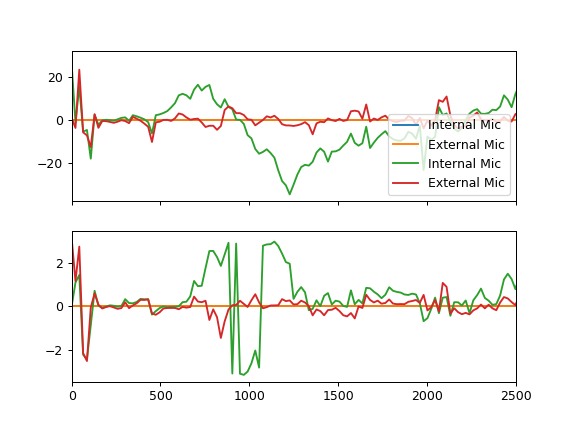

In [34]:
fig,ax = plt.subplots(2,sharex=True)

fig.set_label('Initial position (open) recordings, internal vs external spectra')

for n in range(len(dfiles)):
    ax[0].plot(ff,20*np.log10(np.abs(tfdata[n][0]['mic2']/tfdata[0][0]['mic2'])), label='Internal Mic')
    ax[1].plot(ff,(np.angle(tfdata[n][0]['mic2']/tfdata[0][0]['mic2'])))

    ax[0].plot(ff,20*np.log10(np.abs(tfdata[n][0]['mic1']/tfdata[0][0]['mic1'])), label='External Mic')
    ax[1].plot(ff,(np.angle(tfdata[n][0]['mic1']/tfdata[0][0]['mic1'])))
    
    # ax[0].axvline(1319, C='r')
    ax[0].legend(loc='lower right')
    ax[0].set_xlim((0, 2500))

<IPython.core.display.Javascript object>


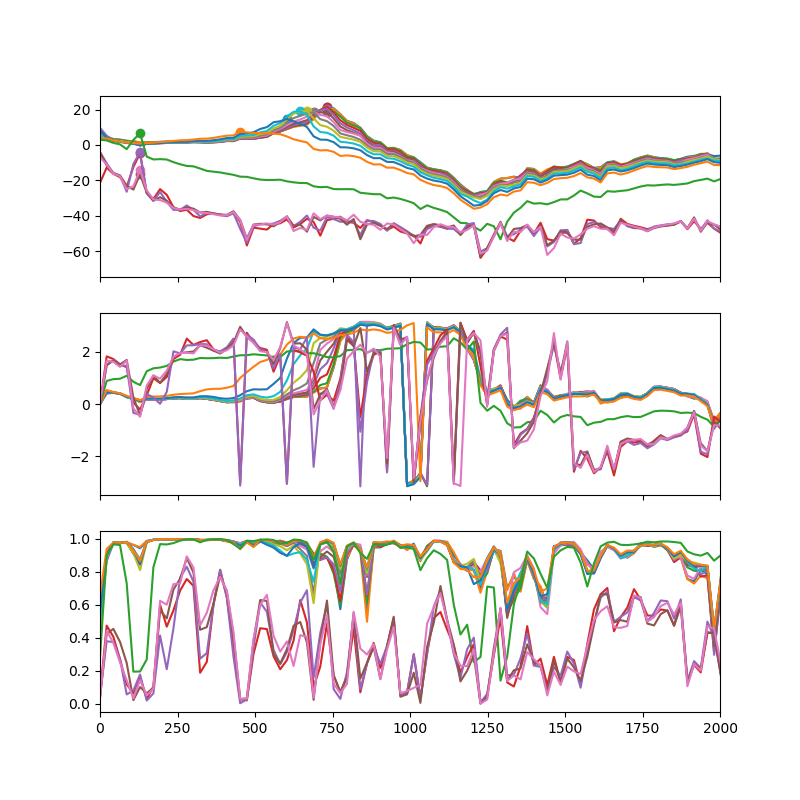

In [210]:
Hfy = [[] for i in range(len(dfiles)-1)]
Hfx = [[] for i in range(len(dfiles)-1)]
for n in range(len(dfiles)-1):
    for recno in range(17):
        h = peakutils.indexes((20*np.log10(np.abs(tfdata[n+1][recno]['tf'])))[:100], thres=0.7, min_dist=1000)
        Hfx[n].extend(h)  
        Hfy[n].extend((20*np.log10(np.abs(tfdata[n+1][recno]['tf'])))[h])    
        
fig,ax = plt.subplots(3,sharex=True, figsize=((8, 8)))
fig.set_label('Transfer functions')

for recno in range(17):
    #ax[0].plot(ff,20*np.log10(np.abs(tfdata[recno]['tf']/tfdata[refno]['tf'])), label='recording %d' % recno)
    ax[0].plot(ff,20*np.log10(np.abs(tfdata[2][recno]['tf'])), label='recording %d' % recno)
    ax[0].scatter(ff[Hfx[1][recno]], Hfy[1][recno])
    ax[0].set_xlim((0, 2000))
#     ax[1].legend(loc='lower right')
#     ax[0].axvline(1319)
    #ax[1].plot(ff,(np.angle(tfdata[recno]['tf']/tfdata[refno]['tf'])))
    ax[1].plot(ff,(np.angle(tfdata[2][recno]['tf'])))
    #coh,ff=tf.cohere(data[:,1],data[:,2],Fs=sr,NFFT=nfft)
    ax[2].plot(ff,np.min([tfdata[2][recno]['coh'],tfdata[0][0]['coh']],axis=0))

In [309]:
gamma=1.4
P_a=101000
rho_a=1.22
c = 343

chimney=0.0139
bore=0.0186
foot=0.16

V=(np.pi*bore**2/4)*foot
const = c**2/(4*np.pi**2*V)

In [341]:
# import pprint as pp

keyvals = np.arange(2.5, 6.75, 0.25)
keyclosed = 5.75
keyincr = [(k-keyclosed)*(-1) for k in keyvals]
areaincr = [np.pi*chimney*1000*incr*2/3 for incr in keyincr]
areaincrSI = [np.pi*chimney*incr*2/3000 for incr in keyincr]
inert1 = [gamma*P_a/(4*np.pi**2*f**2*V) for f in ff[Hfx[0]]]
inert2 = [gamma*P_a/(4*np.pi**2*f**2*V) for f in ff[Hfx[1]]]
effL1 = [inert1[i]*areaincrSI[i]/rho_a for i in range(17)]
effL2 = [inert2[i]*areaincrSI[i]/rho_a for i in range(17)]


pos = [[q for q in keyincr] for i in range(2)]
area = [[q for q in areaincr] for i in range(2)]
inert = [[q for q in inert1], [k for k in inert2]]
effL = [[q for q in effL1], [k for k in effL2]]

for n in range(len(dfiles)-1):
    print(len(ff[Hfx[n]]), len(pos[n]), len(area[n]), len(inert[n]))

17 17 17 17
17 17 17 17


In [342]:
class PrettyTable():
    """Helper class to print pretty tables with proper alignment


    After initialising the class, one adds column definitions to
    the table by using add_column(). This method builds definitions
    to be used later when you start printing the table using:

      * print_header()
      * print_separator()
      * and multiple print_line()

    To customize the output of each column add formatting option to
    the add_column() statement. You can control width and alignment of
    both header and columns. Specify alignment with a single character:
      * left '<', center '=', and right '>'
      * header_alignment defaults to left '<'
      * column_alignment defaults to right '>'

    In addition you can specify the formatting of the actual column value 
    using the value_format parameter which is applied before the column 
    alignment.

    Default separator is a line consisting of '-' matching column widths,
    and a column separator of '   ' (three spaces). These can however
    be changed through the use of column_separator and replace_space_char.
    Try calling with column_separator=' | ', and replace_space_char='-'.
    """
    HEADER_PART = '{0:{1}{2}}'
    ROW_PART = '{{:{0}{1}}}'

    def __init__(self,
                 column_separator = '   ',
                 line_char = '-',
                 replace_space_char=None):

        self._column_separator = column_separator

        if replace_space_char == None:
            self._replaced_column_separator = column_separator
        else:
            self._replaced_column_separator = column_separator.replace(' ', replace_space_char)
        self._line_char = line_char

        self._header_text = []
        self._header_line = []
        self._row_format = []
        self._column_formats = []
        self._joined_row_format = None


    def add_column(self, title, width,
                   header_alignment='<',
                   column_alignment='>',
                   value_format = '{}'):
        """ Adds a new column to the table

        Extends the current header_text, header_line and 
        row_format with proper text and alignment. Pushes the 
        format to used for values in this column to column_formats for
        later use in print_line()
        """

        self._header_text.append(self.HEADER_PART
                                     .format(title,
                                             header_alignment,
                                             width))

        self._header_line.append(self.HEADER_PART
                                     .format(self._line_char * width,
                                             header_alignment,
                                             width))

        self._row_format.append(self.ROW_PART
                                    .format(column_alignment,
                                            width))

        self._column_formats.append(value_format)

    def print_header(self):
        """ Prints a header line, generated in add_column()"""
        print(self._column_separator.join(self._header_text))


    def print_separator(self):
        """ Prints a separator line, generated in add_column()"""
        print(self._replaced_column_separator.join(self._header_line))


    def print_line(self, *columns):
        """ Print a line in the table

        First we build a list of the formatted version of all column values,
        before printing this list using the row format
        """
        if self._joined_row_format == None:
            self._joined_row_format = self._column_separator.join(self._row_format)

        formatted_values = [self._column_formats[i].format(value)
                                 for (i, value) in enumerate(columns)]
        print(self._joined_row_format.format(*formatted_values))

In [346]:
def extended_print_example(data):

    table = PrettyTable()
    table.add_column('Resonant freq [Hz]', 20, value_format='{0:.4f}')
    table.add_column('Key displacement [mm]', 20)
    # Notice how the column width is 10, but the values is formatted to
    # max width of 5 and padded with '*' and always showing sign character
    # and finally this formatted value is left aligned...
    table.add_column('A (flow area) [mm^3]', 20, value_format='{0:.4f}')
    table.add_column('l (end length) [mm]', 20, value_format='{0:4f}')
    table.add_column('L (inertance) [Pa m^-3 s^2]', 30, value_format='{0:.4f}')
    table.print_header()
    table.print_separator()

    for line in data:
        table.print_line(*line)

In [349]:
DATA1 = []
for n in range(17):
    DATA1.append((ff[Hfx[0]][n], pos[0][n], area[0][n], effL[0][n]*1000, inert[0][n]))
    
DATA2 = []
for n in range(17):
    DATA2.append((ff[Hfx[1]][n], pos[1][n], area[1][n], effL[1][n]*1000, inert[1][n]))

In [350]:
extended_print_example(DATA1)

Resonant freq [Hz]     Key displacement [mm]   A (flow area) [mm^3]   l (end length) [mm]    L (inertance) [Pa m^-3 s^2]   
--------------------   --------------------   --------------------   --------------------   ------------------------------
            732.1289                   3.25                94.6143              11.919986                         153.7017
            732.1289                    3.0                87.3363              11.003064                         153.7017
            732.1289                   2.75                80.0583              10.086142                         153.7017
            732.1289                    2.5                72.7802               9.169220                         153.7017
            732.1289                   2.25                65.5022               8.252298                         153.7017
            710.5957                    2.0                58.2242               7.786680                         163.1581
            689

In [351]:
extended_print_example(DATA2)

Resonant freq [Hz]     Key displacement [mm]   A (flow area) [mm^3]   l (end length) [mm]    L (inertance) [Pa m^-3 s^2]   
--------------------   --------------------   --------------------   --------------------   ------------------------------
            732.1289                   3.25                94.6143              11.919986                         153.7017
            732.1289                    3.0                87.3363              11.003064                         153.7017
            732.1289                   2.75                80.0583              10.086142                         153.7017
            732.1289                    2.5                72.7802               9.169220                         153.7017
            732.1289                   2.25                65.5022               8.252298                         153.7017
            732.1289                    2.0                58.2242               7.335376                         153.7017
            689